### Imports 

# Deep Learning with Sequential Data: LSTM Networks

## Key Points:

1. **Purpose**: Demonstrating how to use sequential data in neural networks, specifically with Long Short-Term Memory (LSTM) networks.

2. **Data Preparation**:
   - Using S&P 500 data with hidden Markov model features
   - Adding rolling returns and a target for regression
   - Applying log transformation and min-max scaling to non-stationary columns

3. **Sequencing Data**:
   - Custom `split_sequence` function to prepare data for LSTM
   - Creates sequences of past data (e.g., 8 time steps) to predict future values

4. **LSTM Network Structure**:
   - Input dimensions, hidden dimensions, layer dimensions, and output dimensions
   - LSTM layer followed by fully connected layers
   - Initialization of hidden state and cell state

5. **Training**:
   - Using Mean Squared Error (MSE) loss for regression
   - Adam optimizer
   - Plotting loss over epochs to visualize training progress

6. **Alternative Approaches**:
   - Mentioned 1D Convolutional Neural Networks as an alternative to LSTM
   - Classification approach using Binary Cross Entropy loss (not implemented in this example)

7. **Limitations and Applications**:
   - Author notes limited success with this type of analysis for market prediction
   - Provides code structure for those interested in exploring LSTM with sequential data

8. **Next Steps**:
   - Moving on to reinforcement learning
   - Future lessons on training an agent to trade, starting with a sine wave and progressing to Apple stock trading


In [1]:
# Data Management
import numpy as np
import pandas as pd
import polars as pl  # Using Polars for data management

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Statistics
from statsmodels.tsa.stattools import adfuller

# Deep Learning
import torch
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt

### Data Extraction

In [2]:
# Load data from saved file using Polars
df = pl.read_csv("data/HMM-SPY.csv")

print(f"Length: {len(df)}")

df.columns

Length: 852


['Date',
 'Open',
 'Adj Close',
 'Returns',
 'Range',
 'MA_12',
 'MA_21',
 'HMM',
 'MA_Signal',
 'HMM_Signal',
 'Main_Signal',
 'lrets_bench',
 'bench_prod',
 'bench_prod_exp',
 'lrets_strat',
 'lrets_prod',
 'strat_prod_exp']

In [3]:
df_uf = df.clone()
useful_features = ["Open", "Adj Close", "MA_12", "MA_21", "HMM", "lrets_bench", "lrets_strat"]
df_uf = df.select(useful_features)

df_uf.head(2)

Open,Adj Close,MA_12,MA_21,HMM,lrets_bench,lrets_strat
f64,f64,f64,f64,i64,f64,f64
256.820007,242.321487,233.62229,238.259514,2,0.009351,0.0
257.559998,243.454041,234.584504,238.076622,3,0.004663,-0.0


In [4]:
df_uf.dtypes

[Float64, Float64, Float64, Float64, Int64, Float64, Float64]

In [5]:
# Add Rolling Returns and TARGET
# Compute the rolling mean for 'lrets_bench'
df_uf = df_uf.with_columns(
    pl.col("lrets_bench").rolling_mean(window_size=10).alias("lrets_bench_roll")
)
# Shift the 'lrets_strat' column to create the 'TARGET' column
df_uf = df_uf.with_columns(
    pl.col("lrets_strat").shift(1).alias("TARGET")
)
# Drop rows with null values
df_uf = df_uf.drop_nulls()
df_uf.head()
# If we denote the log return at time t as r(t), then this operation is creating a target variable y(t) such that:
# y(t) = r(t+1)

Open,Adj Close,MA_12,MA_21,HMM,lrets_bench,lrets_strat,lrets_bench_roll,TARGET
f64,f64,f64,f64,i64,f64,f64,f64,f64
264.820007,248.068802,244.6132,238.964305,1,-0.013603,-0.003063,0.003279,-0.000604
264.01001,248.587906,245.47986,239.758611,1,0.00209,-0.0,0.002553,-0.003063
263.209991,248.719986,246.201024,240.785478,2,0.000531,0.0,0.00214,-0.0
265.609985,250.824539,246.909612,242.198377,3,0.008426,-0.008393,0.00263,0.0
263.390015,248.918198,247.364958,242.988414,2,-0.007629,0.00201,0.001829,-0.008393


In [6]:
from statsmodels.tsa.stattools import adfuller
import polars as pl
import numpy as np

# Define a function to check if a series is non-stationary
def is_non_stationary(series):
    # Remove NaN values from NumPy array
    series = series[~np.isnan(series)]
    if len(series) == 0:
        return False  # Return False if series is empty after dropping nulls
    dftest = adfuller(series)
    p_value = dftest[1]
    t_test = dftest[0] < dftest[4]["1%"]
    # Return True if p-value > 0.05 or t-statistic doesn't exceed 1% critical value
    return p_value > 0.05 or not t_test

# Initialize list to store non-stationary column names
non_stationaries = []

# Iterate through each column in the dataframe
for col in df_uf.columns:
    series = df_uf[col].to_numpy()
    if is_non_stationary(series):
        non_stationaries.append(col)

# Print results
print(f"Non-Stationary Features Found: {len(non_stationaries)}")
print(non_stationaries)

# Trading Implications:
# 1. Non-stationary features often include raw price levels, cumulative indicators, and some volatility measures.
# 2. Stationary features are typically returns, oscillating indicators, and relative strength measures.
# 3. Non-stationary features may require differencing or other transformations before use in many statistical models.
# 4. Cointegration analysis often involves finding stationary relationships between non-stationary series.
# 5. Mean-reversion strategies typically work better with stationary series.
# 6. Trend-following strategies might utilize information from non-stationary series.
# 7. Risk models and volatility forecasts may need adjustment when dealing with non-stationary data.
# 8. Feature engineering might involve creating stationary features from non-stationary ones (e.g., price to moving average ratio).
# 9. Some machine learning models (e.g., certain neural networks) can handle non-stationary data better than traditional statistical models.
# 10. Always be cautious of spurious correlations when working with non-stationary financial time series.

# Note: If results still differ from the pandas version, consider:
# - Checking for data type differences between pandas and Polars columns
# - Verifying that the data in both versions is identical
# - Examining any preprocessing steps that might affect the stationarity test

Non-Stationary Features Found: 4
['Open', 'Adj Close', 'MA_12', 'MA_21']


In [7]:
# Convert Non-Stationary items to log
df_uf[non_stationaries] = np.log(df_uf[non_stationaries])

# Explanation:
# 1. Purpose: This code applies a logarithmic transformation to the non-stationary features identified earlier.
#
# 2. Why use logarithmic transformation:
#    - Helps stabilize variance in time series data
#    - Can make multiplicative relationships additive
#    - Often makes non-stationary data more stationary
#    - Reduces the impact of large outliers
#
# 3. Financial implications:
#    - Log prices: Represent relative (percentage) changes rather than absolute changes
#    - Log-transformed moving averages: Reflect proportional rather than absolute price levels
#
# 4. Benefits for analysis:
#    - May improve the performance of statistical models assuming stationarity
#    - Can help in identifying trends and patterns that are not apparent in raw price data
#    - Useful for comparing assets with different price scales
#
# 5. Interpretation:
#    - Differences in log prices approximate percentage returns
#    - Useful for calculating continuously compounded returns
#
# 6. Caution:
#    - Ensure all values are positive before applying log transformation
#    - Be aware that log transformation can affect the interpretation of your results
#    - Some models may require you to reverse this transformation for final predictions
#
# 7. Alternative approaches:
#    - Differencing: Another common method to induce stationarity
#    - Percent change: Similar to log returns but easier to interpret
#
# 8. Next steps:
#    - Re-test for stationarity after this transformation
#    - Consider additional transformations if necessary (e.g., differencing of log prices)
#    - Adjust your analysis and modeling techniques to work with log-transformed data

In [8]:
import polars as pl
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Min Max Scaling
scaler = MinMaxScaler()

# Apply Min-Max scaling to all columns except the last one
scaled_data = scaler.fit_transform(df_uf.select(pl.all().exclude(df_uf.columns[-1])).to_numpy())

# Create a new DataFrame with scaled data
df_scaled = pl.DataFrame(scaled_data, schema=df_uf.columns[:-1])

# Add back the last column (assuming it's the target variable)
df_scaled = df_scaled.with_columns(df_uf.select(df_uf.columns[-1]))

print(df_scaled.head(10))

# Explanation:
# 1. Purpose: This code applies Min-Max scaling to all features except the last column (typically the target variable).
#
# 2. Why use Min-Max scaling:
#    - Normalizes features to a fixed range, typically [0, 1]
#    - Preserves zero values and does not center the data
#    - Useful when you need bounded intervals
#
# 3. Financial implications:
#    - Helps compare features with different scales (e.g., price vs. volume)
#    - Useful for algorithms sensitive to feature magnitudes (e.g., neural networks, k-nearest neighbors)
#    - Can help in visualizing and comparing different financial indicators
#
# 4. Benefits for analysis:
#    - Prevents features with larger magnitudes from dominating the analysis
#    - Can improve the convergence of gradient descent algorithms
#    - Useful for techniques that rely on distances between data points
#
# 5. Interpretation:
#    - Scaled values represent the relative position within the feature's range
#    - 0 represents the minimum value, 1 represents the maximum value
#
# 6. Caution:
#    - Sensitive to outliers, as min and max values define the scaling
#    - May not be suitable if the true min/max of a feature is unknown (e.g., in streaming data)
#    - Can compress information in features with larger ranges
#
# 7. Alternative approaches:
#    - StandardScaler: Scales to zero mean and unit variance
#    - RobustScaler: Uses median and interquartile range, less sensitive to outliers
#    - Normalization: Scaling individual samples to unit norm
#
# 8. Next steps:
#    - Ensure to use the same scaler for transforming test/new data
#    - Consider the impact of scaling on feature importance interpretation
#    - Evaluate model performance with and without scaling to assess its impact
#
# 9. Note on implementation:
#    - We exclude the last column assuming it's the target variable
#    - Adjust the indexing if your target variable is in a different position
#    - The scaler object should be saved to apply the same transformation to future data

shape: (10, 9)
┌──────────┬───────────┬──────────┬──────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ Open     ┆ Adj Close ┆ MA_12    ┆ MA_21    ┆ … ┆ lrets_benc ┆ lrets_stra ┆ lrets_ben ┆ TARGET    │
│ ---      ┆ ---       ┆ ---      ┆ ---      ┆   ┆ h          ┆ t          ┆ ch_roll   ┆ ---       │
│ f64      ┆ f64       ┆ f64      ┆ f64      ┆   ┆ ---        ┆ ---        ┆ ---       ┆ f64       │
│          ┆           ┆          ┆          ┆   ┆ f64        ┆ f64        ┆ f64       ┆           │
╞══════════╪═══════════╪══════════╪══════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0.200641 ┆ 0.177745  ┆ 0.047211 ┆ 0.0      ┆ … ┆ 0.504813   ┆ 0.532233   ┆ 0.681136  ┆ -0.000604 │
│ 0.196512 ┆ 0.180398  ┆ 0.052376 ┆ 0.004967 ┆ … ┆ 0.582264   ┆ 0.595795   ┆ 0.664534  ┆ -0.003063 │
│ 0.192422 ┆ 0.181072  ┆ 0.056659 ┆ 0.011364 ┆ … ┆ 0.574569   ┆ 0.595795   ┆ 0.655088  ┆ -0.0      │
│ 0.204655 ┆ 0.191766  ┆ 0.060856 ┆ 0.020121 ┆ … ┆ 0.613533   ┆ 0.421644   ┆

In [9]:
import polars as pl
import numpy as np

# Split X and Y data
X_data = df_scaled.select(pl.all().exclude(df_scaled.columns[-1])).to_numpy()
y_data = df_scaled.select(df_scaled.columns[-1]).to_numpy().flatten()

print(f"X_data: \n {X_data[:1]} \n")
print(f"y: \n {y_data[0:5]} \n")

# Explanation:
# 1. Purpose: This code separates the feature variables (X_data) from the target variable (y_data).
#
# 2. Data Structure:
#    - X_data: 2D numpy array containing all features (independent variables)
#    - y_data: 1D numpy array containing the target variable (dependent variable)
#
# 3. Financial Implications:
#    - X_data typically includes price levels, technical indicators, and other relevant features
#    - y_data often represents the variable we're trying to predict (e.g., future returns, price movements)
#
# 4. Importance in Machine Learning:
#    - This split is crucial for supervised learning tasks in finance
#    - Allows models to learn relationships between features and the target variable
#
# 5. X_data (Features):
#    - Each row represents a time point or observation
#    - Each column represents a different feature or indicator
#    - In finance, might include open/close prices, moving averages, volatility measures, etc.
#
# 6. y_data (Target):
#    - Represents the variable we're aiming to predict
#    - In trading, could be future price movements, returns, or trading signals
#
# 7. Data Handling:
#    - Using Polars for efficient data manipulation
#    - Converting to NumPy arrays for compatibility with most ML libraries
#
# 8. Considerations:
#    - Ensure time-series integrity: X_data at time t should only include information available at or before t
#    - Be cautious of look-ahead bias when preparing features and targets
#
# 9. Next Steps:
#    - Further split this data into training and testing sets
#    - Consider cross-validation strategies suitable for time-series data
#    - Evaluate the need for any additional preprocessing or feature engineering
#
# 10. Note on Implementation:
#     - Assumes the target variable is the last column in the DataFrame
#     - Adjust indexing if your target variable is positioned differently
#     - The `flatten()` method is used to ensure y_data is a 1D array, as required by most ML algorithms

X_data: 
 [[0.20064088 0.1777452  0.0472111  0.         0.33333333 0.50481327
  0.53223262 0.6811359 ]] 

y: 
 [-0.00060402 -0.00306336 -0.          0.         -0.00839313] 



### Data Sequencing

In [10]:
# split a univariate sequence into samples

import polars as pl
import numpy as np

def split_sequence(input_data, n_steps):
    """
    Split a multivariate time series into samples for sequence prediction.
    
    Args:
    input_data (np.array): 2D NumPy array where each row is a time step and each column is a feature
    n_steps (int): Number of time steps to use as input
    
    Returns:
    np.array: 3D NumPy array of input sequences
    """
    X = []
    for i in range(len(input_data) - n_steps + 1):
        # Extract sequence of `n_steps` time steps for all features except the last column
        seq_x = input_data[i:(i + n_steps), :-1]
        X.append(seq_x)
    return np.array(X)

# Example usage (assuming df_scaled is your Polars DataFrame):
# input_data = df_scaled.to_numpy()
# X = split_sequence(input_data, n_steps=10)
# print(f"Shape of X: {X.shape}")

# Explanation:
# 1. Purpose: This function prepares time series data for sequence-based models (e.g., LSTM, GRU).
#
# 2. Function Input:
#    - input_data: Entire dataset including features and target
#    - n_steps: The number of historical time steps to use as input (lookback period)
#
# 3. Function Output:
#    - 3D NumPy array: (samples, time steps, features)
#
# 4. Financial Implications:
#    - Allows models to learn from sequences of historical data
#    - Crucial for capturing temporal dependencies in financial time series
#
# 5. Use in Trading:
#    - Can be used to prepare data for predicting future price movements
#    - Helps in developing models that consider recent market trends
#
# 6. Sliding Window Approach:
#    - Creates overlapping sequences, moving one time step at a time
#    - Maximizes the use of available data
#
# 7. Feature Handling:
#    - Excludes the last column (assumed to be the target variable) from the input sequences
#    - Ensures no future information leakage in the input features
#
# 8. Considerations:
#    - Choose n_steps carefully: too short might miss important patterns, too long might introduce noise
#    - Consider the frequency of your data when selecting n_steps (e.g., daily vs. hourly data)
#
# 9. Potential Enhancements:
#    - Add option to include the target variable in the output for multi-step forecasting
#    - Implement stride parameter for non-overlapping sequences if needed
#
# 10. Next Steps:
#     - Prepare corresponding target values for each sequence
#     - Split the resulting sequences into training and testing sets
#     - Consider normalization within each sequence for certain types of models
#
# 11. Note on Implementation:
#     - This function assumes a 2D NumPy array input, so convert your Polars DataFrame accordingly
#     - Adjust the indexing if your target variable is not in the last column

In [11]:
import numpy as np

# Choose a number of time steps in each sample window
n_timesteps = 8

# Split X into sequence samples
X = split_sequence(X_data, n_timesteps)

# Adjust y to start at the right point
y = y_data[n_timesteps:]

# Print shapes for verification
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Explanation:
# 1. Purpose: This code prepares the input features and target variable for sequence-based modeling.
#
# 2. Time Steps (n_timesteps):
#    - Set to 8, meaning each input sequence will contain 8 historical time steps
#    - In finance: Could represent 8 days, weeks, or any other time unit depending on data frequency
#
# 3. X Preparation:
#    - Uses the split_sequence function to create overlapping sequences of input features
#    - Results in a 3D array: (samples, time steps, features)
#
# 4. Y Adjustment:
#    - Aligns the target variable with the input sequences
#    - Starts from the n_timesteps index to match the end of each input sequence
#
# 5. Financial Implications:
#    - Allows models to learn from recent historical patterns (last 8 time steps)
#    - Crucial for capturing short-term trends and seasonality in financial data
#
# 6. Trading Strategy Considerations:
#    - 8 time steps might represent a trading week (if using daily data) or two trading weeks
#    - Adjust n_timesteps based on the believed relevant historical context for your trading strategy
#
# 7. Data Structure:
#    - X: Each sample is a sequence of 8 time steps, each containing multiple features
#    - y: Each value corresponds to the target variable for the time step immediately following its X sequence
#
# 8. Model Input Preparation:
#    - Suitable for sequence models like LSTM, GRU, or 1D CNNs in PyTorch or TensorFlow
#
# 9. Potential Risks:
#    - Ensure no data leakage: y values should not be included in their corresponding X sequences
#    - Be aware of the trade-off: larger n_timesteps captures more history but reduces the number of training samples
#
# 10. Alternatives to Consider:
#     - Variable-length sequences if different lookback periods are relevant for different market conditions
#     - Multiple input sequences with different timesteps to capture both short and long-term patterns
#
# 11. Next Steps:
#     - Split X and y into training and testing sets
#     - Consider additional feature engineering within each sequence
#     - Normalize or standardize data within each sequence if required by your model
#
# 12. Validation:
#     - Ensure X.shape[0] == y.shape[0] to confirm alignment
#     - Verify that the first y value corresponds to the target for the last time step of the first X sequence

Shape of X: (836, 8, 7)
Shape of y: (835,)


In [12]:
import numpy as np

# Summarize and check the X sequence
print("\nX summary:")
for i in range(min(2, len(X))):
    print(f"Sequence {i+1}:")
    print(X[i])
    print()

# Summarize and check the y sequence
print("\ny summary:")
for i in range(min(2, len(y))):
    print(f"Target {i+1}: {y[i]}")

# Explanation:
# 1. Purpose: This code provides a visual inspection of the prepared X sequences and y targets.
#
# 2. X Sequence Visualization:
#    - Displays the first two sequences from X
#    - Each sequence represents 8 time steps (as set by n_timesteps)
#    - Each time step contains multiple features
#
# 3. Y Target Visualization:
#    - Shows the first two target values from y
#    - Each value corresponds to the target variable for the time step following its X sequence
#
# 4. Financial Data Interpretation:
#    - X sequences: Represent historical patterns of financial indicators
#    - y values: Typically represent future price movements or returns
#
# 5. Sequence Structure:
#    - Each row in X represents a time step
#    - Each column represents a different feature (e.g., price, volume, technical indicators)
#
# 6. Data Alignment Check:
#    - Ensures that X sequences and y targets are properly aligned
#    - Critical for accurate model training and prediction
#
# 7. Feature Identification:
#    - Allows for quick verification of included features
#    - Helps in identifying any anomalies or unexpected values
#
# 8. Scale Inspection:
#    - If data is normalized/scaled, values should typically be between 0 and 1
#    - Helps in verifying the effectiveness of previous preprocessing steps
#
# 9. Temporal Relationship:
#    - The last row of each X sequence should immediately precede its corresponding y value
#    - Crucial for maintaining the temporal integrity of the time series
#
# 10. Model Input Verification:
#     - Confirms that the data is in the correct format for sequence models (e.g., LSTM, GRU)
#     - 3D structure of X: (samples, time steps, features)
#
# 11. Potential Red Flags:
#     - Unexpected feature values or ranges
#     - Misalignment between X sequences and y targets
#     - Inconsistent number of features


X summary:
Sequence 1:
[[0.20064088 0.1777452  0.0472111  0.         0.33333333 0.50481327
  0.53223262]
 [0.19651226 0.1803982  0.05237563 0.00496689 0.33333333 0.58226423
  0.59579465]
 [0.19242205 0.18107234 0.05665925 0.01136369 0.66666667 0.57456887
  0.59579465]
 [0.20465531 0.191766   0.06085597 0.02012078 1.         0.61353273
  0.42164448]
 [0.19334353 0.18208334 0.06354648 0.02499517 0.66666667 0.53429341
  0.63750451]
 [0.19605276 0.1803982  0.06564806 0.02923554 0.66666667 0.56539409
  0.68835771]
 [0.20206512 0.20033197 0.06962947 0.0346993  1.         0.64946563
  0.7835711 ]
 [0.21426199 0.21142959 0.07541099 0.04019253 0.66666667 0.61510364
  0.79955837]]

Sequence 2:
[[0.19651226 0.1803982  0.05237563 0.00496689 0.33333333 0.58226423
  0.59579465]
 [0.19242205 0.18107234 0.05665925 0.01136369 0.66666667 0.57456887
  0.59579465]
 [0.20465531 0.191766   0.06085597 0.02012078 1.         0.61353273
  0.42164448]
 [0.19334353 0.18208334 0.06354648 0.02499517 0.66666667 0.5

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader

class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return self.length

# Trainset
trainset = dataset(X, y)

# Data Loader
trainloader = DataLoader(trainset, batch_size=20, shuffle=False, drop_last=True) 

# Explanation:
# 1. Purpose: This code creates a custom PyTorch Dataset and DataLoader for efficient handling of financial time series data.
#
# 2. Custom Dataset Class:
#    - Inherits from torch.utils.data.Dataset
#    - Converts NumPy arrays to PyTorch tensors
#    - Provides methods for accessing data and determining dataset size
#
# 3. Data Types:
#    - Uses torch.float32 for both X and y
#    - Ensures compatibility with PyTorch models and operations
#
# 4. Financial Data Handling:
#    - X: 3D tensor (samples, time_steps, features) for sequence data
#    - y: 1D tensor of target values
#
# 5. DataLoader Creation:
#    - Batch size of 20: Processes 20 sequences at a time
#    - shuffle=False: Maintains temporal order, crucial for time series data
#
# 6. Implications for Financial Modeling:
#    - Enables efficient batch processing of financial time series
#    - Preserves the temporal structure of the data
#    - Facilitates training of deep learning models (e.g., LSTM, GRU) on financial data
#
# 7. Batch Size Considerations:
#    - 20 sequences per batch balances between computational efficiency and granularity
#    - May need adjustment based on model complexity and available computational resources
#
# 8. No Shuffling:
#    - Maintains the chronological order of financial data
#    - Important for capturing time-dependent patterns in markets
#
# 9. Memory Management:
#    - Converts entire dataset to tensors at initialization
#    - Efficient for smaller datasets, may need modification for very large financial datasets
#
# 10. Flexibility:
#     - Easy to extend for including additional financial indicators or features
#     - Can be modified to handle multiple input sequences or output targets
#
# 11. Potential Enhancements:
#     - Add data normalization within the Dataset class if not done previously
#     - Implement on-the-fly data augmentation techniques specific to financial data
#
# 12. Usage in Training Loop:
#     - Allows easy iteration over batches of financial data during model training
#     - Facilitates implementation of mini-batch gradient descent
#
# 13. Considerations for Production:
#     - May need to implement real-time data feeding for live trading scenarios
#     - Consider adding functionality for handling out-of-sample data or walk-forward testing

In [14]:
print(trainset.X.shape)
trainset.X[0:3]

torch.Size([836, 8, 7])


tensor([[[0.2006, 0.1777, 0.0472, 0.0000, 0.3333, 0.5048, 0.5322],
         [0.1965, 0.1804, 0.0524, 0.0050, 0.3333, 0.5823, 0.5958],
         [0.1924, 0.1811, 0.0567, 0.0114, 0.6667, 0.5746, 0.5958],
         [0.2047, 0.1918, 0.0609, 0.0201, 1.0000, 0.6135, 0.4216],
         [0.1933, 0.1821, 0.0635, 0.0250, 0.6667, 0.5343, 0.6375],
         [0.1961, 0.1804, 0.0656, 0.0292, 0.6667, 0.5654, 0.6884],
         [0.2021, 0.2003, 0.0696, 0.0347, 1.0000, 0.6495, 0.7836],
         [0.2143, 0.2114, 0.0754, 0.0402, 0.6667, 0.6151, 0.7996]],

        [[0.1965, 0.1804, 0.0524, 0.0050, 0.3333, 0.5823, 0.5958],
         [0.1924, 0.1811, 0.0567, 0.0114, 0.6667, 0.5746, 0.5958],
         [0.2047, 0.1918, 0.0609, 0.0201, 1.0000, 0.6135, 0.4216],
         [0.1933, 0.1821, 0.0635, 0.0250, 0.6667, 0.5343, 0.6375],
         [0.1961, 0.1804, 0.0656, 0.0292, 0.6667, 0.5654, 0.6884],
         [0.2021, 0.2003, 0.0696, 0.0347, 1.0000, 0.6495, 0.7836],
         [0.2143, 0.2114, 0.0754, 0.0402, 0.6667, 0.6151, 0.

In [15]:
trainset.y[:10]

tensor([ 0.0098, -0.0001,  0.0086,  0.0013, -0.0068, -0.0081,  0.0000,  0.0045,
         0.0095, -0.0046])

### Construct Neural Network

In [16]:
from torch import nn
from torch.autograd import Variable

class LSTM_Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_Net, self).__init__()
        
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # First fully connected layer
        self.fc1 = nn.Linear(hidden_dim, 5)

        # Second fully connected layer
        self.fc2 = nn.Linear(5, output_dim)
        
    def forward(self, x):
                            
        # Initialize Hidden State with zeros (layer dim = 1, x.size = 64)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
                            
        # Initialize Cell State with zeros
        c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
#         # Outputs - Classification
#         out, (hn, cn) = self.lstm(x, (h0, c0))
#         out = self.fc1(out[:, -1, :])
#         out = torch.sigmoid(self.fc2(out))

        # Regression - Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h0, c0))
        h_out = h_out.view(-1, self.hidden_dim)
        out = self.fc1(h_out)
        out = self.fc2(out)
        
        return out

# Explanation:
# 1. Purpose: This code defines an LSTM (Long Short-Term Memory) neural network for financial time series regression.
#
# 2. Network Architecture:
#    - LSTM layer: Captures temporal dependencies in financial data
#    - Two fully connected layers: For final prediction refinement
#
# 3. LSTM Layer:
#    - input_dim: Number of features in each time step
#    - hidden_dim: Size of the LSTM's hidden state
#    - layer_dim: Number of LSTM layers
#    - batch_first=True: Expects input shape (batch, seq_len, features)
#
# 4. Fully Connected Layers:
#    - fc1: Reduces dimensionality to 5 nodes
#    - fc2: Produces final output (typically 1 for regression tasks)
#
# 5. Forward Pass:
#    - Initializes hidden and cell states with zeros
#    - Processes the entire sequence through LSTM
#    - Uses only the final hidden state for prediction
#
# 6. Financial Modeling Implications:
#    - Suitable for predicting continuous values (e.g., prices, returns)
#    - Can capture complex temporal patterns in financial time series
#    - Flexible for various prediction horizons (adjust input sequence length)
#
# 7. Potential Applications:
#    - Price forecasting
#    - Volatility prediction
#    - Risk assessment
#    - Trading signal generation
#
# 8. Model Flexibility:
#    - Can be easily adapted for classification tasks (e.g., trend direction)
#    - Commented-out section shows potential modification for classification
#
# 9. Considerations:
#    - LSTM complexity: Balance between model capacity and overfitting risk
#    - Sequence length: Affects the temporal context considered for predictions
#    - Hidden dimension: Impacts model's ability to capture complex patterns
#
# 10. Hyperparameter Tuning:
#     - Adjust hidden_dim, layer_dim for optimal performance
#     - Consider adding dropout for regularization
#
# 11. Training Considerations:
#     - May require significant data and careful regularization
#     - Consider using techniques like teacher forcing for stable training
#
# 12. Limitations:
#     - May struggle with very long-term dependencies
#     - Sensitive to scaling of input features
#
# 13. Enhancements:
#     - Add attention mechanism for interpretability
#     - Implement bidirectional LSTM for utilizing future context (in backtesting scenarios)

In [17]:
# Initialize model
input_dim = X.shape[2]
hidden_dim = 100
layer_dim = 1
output_dim = 1
model = LSTM_Net(input_dim, hidden_dim, layer_dim, output_dim)
print(f"Model Parameters: {len(list(model.parameters()))}")

# Explanation:
# 1. Purpose: This code initializes the LSTM model with specific dimensions tailored to the financial data.
#
# 2. Model Dimensions:
#    - input_dim: Automatically set to the number of features in each time step (X.shape[2])
#    - hidden_dim: Set to 100, determining the complexity of patterns the LSTM can capture
#    - layer_dim: Set to 1, indicating a single LSTM layer
#    - output_dim: Set to 1, suitable for single-value regression (e.g., price prediction)
#
# 3. Input Dimension (input_dim):
#    - Derived from X.shape[2], ensuring compatibility with the prepared data
#    - Represents the number of financial features or indicators used in each time step
#
# 4. Hidden Dimension (hidden_dim = 100):
#    - Determines the size of the LSTM's hidden state
#    - Impacts the model's capacity to capture complex financial patterns
#    - Trade-off: Larger values increase model capacity but risk overfitting
#
# 5. Layer Dimension (layer_dim = 1):
#    - Single LSTM layer, suitable for many financial prediction tasks
#    - Can be increased for more complex temporal dependencies, at the cost of increased computation
#
# 6. Output Dimension (output_dim = 1):
#    - Set for single-value regression, typical in financial forecasting
#    - Examples: predicting next day's price, return, or volatility
#
# 7. Model Instantiation:
#    - Creates an instance of the LSTM_Net class with the specified dimensions
#
# 8. Model Parameter Count:
#    - Prints the number of trainable parameters in the model
#    - Indicator of model complexity and potential for overfitting
#
# 9. Financial Modeling Implications:
#    - Model structure suitable for various financial prediction tasks
#    - Flexibility to handle multiple input features (technical indicators, market data)
#    - Single output focused on one target variable at a time
#
# 10. Considerations for Financial Applications:
#     - Adjust hidden_dim based on data complexity and available training data
#     - Consider increasing layer_dim for very complex financial time series
#     - Ensure input_dim matches the number of relevant financial indicators used
#
# 11. Potential Enhancements:
#     - Experiment with different hidden_dim values to optimize performance
#     - Consider adding more LSTM layers for complex financial data
#     - Implement dropout or regularization techniques to prevent overfitting
#
# 12. Model Capacity vs. Data Size:
#     - Ensure the model's capacity (determined by hidden_dim and layer_dim) is appropriate for your dataset size
#     - Too large capacity might lead to overfitting, especially with limited financial data
#
# 13. Interpretability:
#     - While powerful, LSTM models can be black boxes. Consider techniques like attention mechanisms for better interpretability in financial contexts

Model Parameters: 8


In [18]:
# Review Model Structure
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

torch.Size([400, 7])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([5, 100])
torch.Size([5])
torch.Size([1, 5])
torch.Size([1])


### Train LSTM Network

In [19]:
epochs = 1000

# # for classification
# criterion = nn.BCELoss() 
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-1)

# Regression
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-1)

losses = []

iter = 0
for epoch in range(epochs):
    for i, (X_train, y_train) in enumerate(trainloader):

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)

        # Calculate loss
        loss = criterion(outputs, y_train.unsqueeze(dim=1))
                       
        # Backward propegation
        loss.backward()

        # Updating parameters
        optimizer.step()

        # Increment iteration
        iter += 1
        
    # Track progress
    if iter % 100 == 0:
        print(f"Loss: {loss}")
        losses.append(loss.detach())

Loss: 1.407182708135224e-06
Loss: 7.062994882289786e-06
Loss: 1.576198656039196e-06
Loss: 1.2261634765309282e-05
Loss: 3.342598517974693e-07
Loss: 3.5728949114854913e-06
Loss: 1.0855494110728614e-05
Loss: 2.495409262337489e-06
Loss: 8.300741001221468e-07
Loss: 2.113051959895529e-05


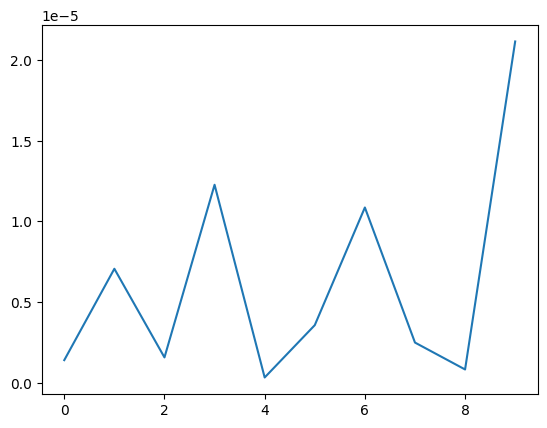

In [20]:
# Review losses
plt.plot(losses)
plt.show()